In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"
    seed: int = 42


config = Config()
sys.path.append(str(config.REPO_ROOT))

### 8.2.4 Examples

In [2]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike-sharing-daily.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

features_of_interest = [
    "days_since_2011",
    "temp",
    "season",
    "windspeed",
    "hum",
]
df_bike_processed["season"] = df_bike_processed["season"].map(
    {"WINTER": 1, "SPRING": 2, "SUMMER": 3, "FALL": 4}
)
X = df_bike_processed[features_of_interest]
y = df_bike_processed["cnt"]

X_sampled = X.sample(n=300, random_state=config.seed)
tree_model = RandomForestRegressor(random_state=config.seed)
tree_model.fit(X, y)

RandomForestRegressor(random_state=42)

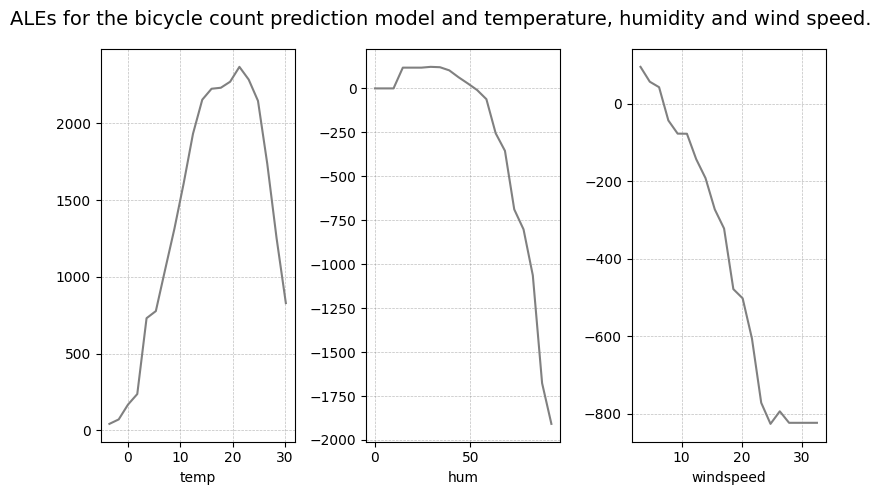

In [3]:
from python.src.utils import AccumulatedLocalEffects

ale = AccumulatedLocalEffects(
    model=tree_model,
    X=X_sampled,
)

fig, axes = plt.subplots(1, 3, figsize=(8, 5))
for i, (feature, ax) in enumerate(zip(["temp", "hum", "windspeed"], axes.ravel())):
    df_ale = ale.accumulated_local_effects(feature, n_grid=20)
    x_min, x_max = df_ale[feature].min(), df_ale[feature].max()
    ax.set_xlabel(feature)
    ax.plot(df_ale[feature], df_ale["ale"], color="gray")
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

fig.suptitle(
    "ALEs for the bicycle count prediction model and temperature, humidity and wind speed.",
    fontsize=14,
)
plt.tight_layout()
plt.show()

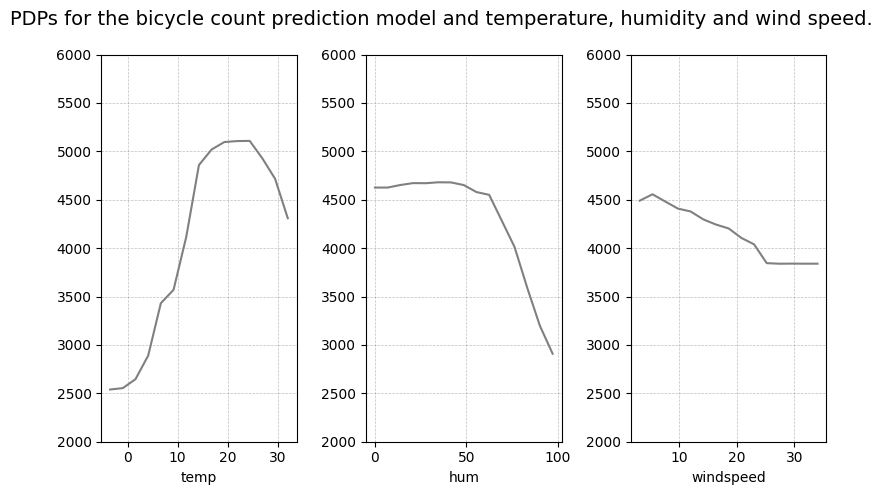

In [4]:
from python.src.utils import PartialDependence

pdp = PartialDependence(
    tree_model, X_sampled, ["temp", "hum", "windspeed"], pred_type="regression"
)

fig, axes = plt.subplots(1, 3, figsize=(8, 5))
for i, (feature, ax) in enumerate(zip(["temp", "hum", "windspeed"], axes.ravel())):
    df_pd = pdp.partial_dependence(feature, n_grid=15)
    x_min, x_max = df_pd[feature].min(), df_pd[feature].max()
    ax.set_ylim(2000, 6000)
    ax.set_xlabel(feature)
    ax.plot(df_pd[feature], df_pd["avg_pred"], color="gray")
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

fig.suptitle(
    "PDPs for the bicycle count prediction model and temperature, humidity and wind speed.",
    fontsize=14,
)
plt.tight_layout()
plt.show()